
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

#Fit a model. Does it beat your baseline?

In [43]:
import numpy as np
import pandas as pd

uci_red = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-red.csv', delimiter=";")
uci_white = pd.read_csv('https://raw.githubusercontent.com/nastyalolpro/project_data/master/build_week_2/winequality-white.csv', delimiter=";")

uci_red['color'] = 'red'
uci_white['color'] = 'white'

df = pd.concat([uci_red, uci_white])
df = df.reset_index(drop=True)

In [44]:
uci_quality = []
for i in df['quality']:
  if i < 6:
    uci_quality.append('low')
  elif (5 < i)&(i < 7):
    uci_quality.append('medium')
  else:
    uci_quality.append('high')

df['quality'] = uci_quality

In [45]:
df['quality'].value_counts()

medium    2836
low       2384
high      1277
Name: quality, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['quality'], random_state=42)

In [47]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['quality'], random_state=42)

##Baseline

In [48]:
#target distribution
dist = train['quality'].value_counts(normalize = True)
dist

medium    0.436613
low       0.366851
high      0.196536
Name: quality, dtype: float64

In [49]:
print('Baseline is', dist.max())

Baseline is 0.43661294202549916


##Arrange data into X features matrix and y target vector

In [50]:
target = 'quality'

X_train = train.drop(columns = target)
y_train = train[target]

X_val = val.drop(columns = target)
y_val = val[target]

X_test = test.drop(columns = target)
y_test = test[target]

##Random forest classifier

In [51]:
!pip install category_encoders==2.*

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
# from sklearn.impute import SimpleImputer
import category_encoders as ce

In [53]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(max_depth = 30, n_estimators=100, random_state=42, n_jobs=-1)
    )

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.7076923076923077


###(Default) feature umportances

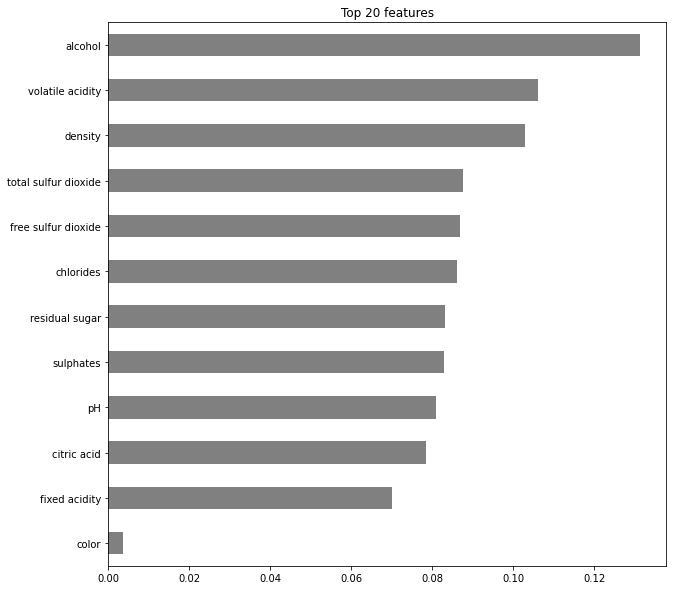

In [54]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n=20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#Try xgboost.

In [55]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    )

pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.6134615384615385


###Early stopping of the model

In [56]:
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000, 
    max_depth = 7, 
    learning_rate = .2,
    n_jobs = -1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.277123	validation_1-merror:0.405769
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.253308	validation_1-merror:0.379808
[2]	validation_0-merror:0.235506	validation_1-merror:0.369231
[3]	validation_0-merror:0.22829	validation_1-merror:0.369231
[4]	validation_0-merror:0.210007	validation_1-merror:0.365385
[5]	validation_0-merror:0.20279	validation_1-merror:0.366346
[6]	validation_0-merror:0.194612	validation_1-merror:0.359615
[7]	validation_0-merror:0.188357	validation_1-merror:0.355769
[8]	validation_0-merror:0.185711	validation_1-merror:0.353846
[9]	validation_0-merror:0.180419	validation_1-merror:0.349038
[10]	validation_0-merror:0.171518	validation_1-merror:0.349038
[11]	validation_0-merror:0.16382	validation_1-merror:0.348077
[12]	validation_0-merror:0.160212	validation_1-merror:0.346154
[13]	validation_0-merror:0.1568

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

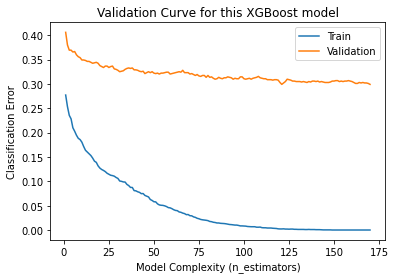

In [57]:
import matplotlib.pyplot as plt

#what does classification error mean
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [58]:
# do i need to try regression model ar try ajusting classes?
score_with = model.score(X_val_encoded, y_val)
print(f'Validation Accuracy: {score_with}')

Validation Accuracy: 0.7009615384615384


In [59]:
X_test_encoded = encoder.transform(X_test)

score_with = model.score(X_test_encoded, y_test)
print(f'Test Accuracy: {score_with}')

Test Accuracy: 0.6953846153846154


#Get your model's permutation importances.

In [60]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [61]:
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.2,
                                              max_delta_step=0, max_depth=7,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=-1,
                                              nthread=None,
                                              objective='multi:softprob',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [62]:
feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

color                   0.000385
citric acid             0.017115
fixed acidity           0.023846
pH                      0.031154
sulphates               0.035385
density                 0.038846
chlorides               0.041923
residual sugar          0.044231
free sulfur dioxide     0.046923
total sulfur dioxide    0.056346
volatile acidity        0.081538
alcohol                 0.136346
dtype: float64

In [63]:
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

Weight,Feature
0.1363 ± 0.0200,alcohol
0.0815 ± 0.0121,volatile acidity
0.0563 ± 0.0221,total sulfur dioxide
0.0469 ± 0.0162,free sulfur dioxide
0.0442 ± 0.0054,residual sugar
0.0419 ± 0.0120,chlorides
0.0388 ± 0.0140,density
0.0354 ± 0.0119,sulphates
0.0312 ± 0.0147,pH
0.0238 ± 0.0130,fixed acidity


#Make at least 1 partial dependence plot to explain your model.

##Make multiple PDPs with 1 feature in isolation

In [68]:
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 57.7MB 71kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=e4cbb713fa8a4aa4db2b7b70a2d0370e0d7775113dfe535601e208f953d1e2d6
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456446 sha256=f3b2229b57f0323efd72305a2511e9fb9791ca6c7ede04c129823db4486b2549
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [71]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'alcohol'

isolated = pdp_isolate(
    model = model,
    dataset = X_val_encoded,
    model_features = X_val_encoded.columns,
    feature = feature
)

(<Figure size 1080x1080 with 4 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f9e34b22630>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9e36090198>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


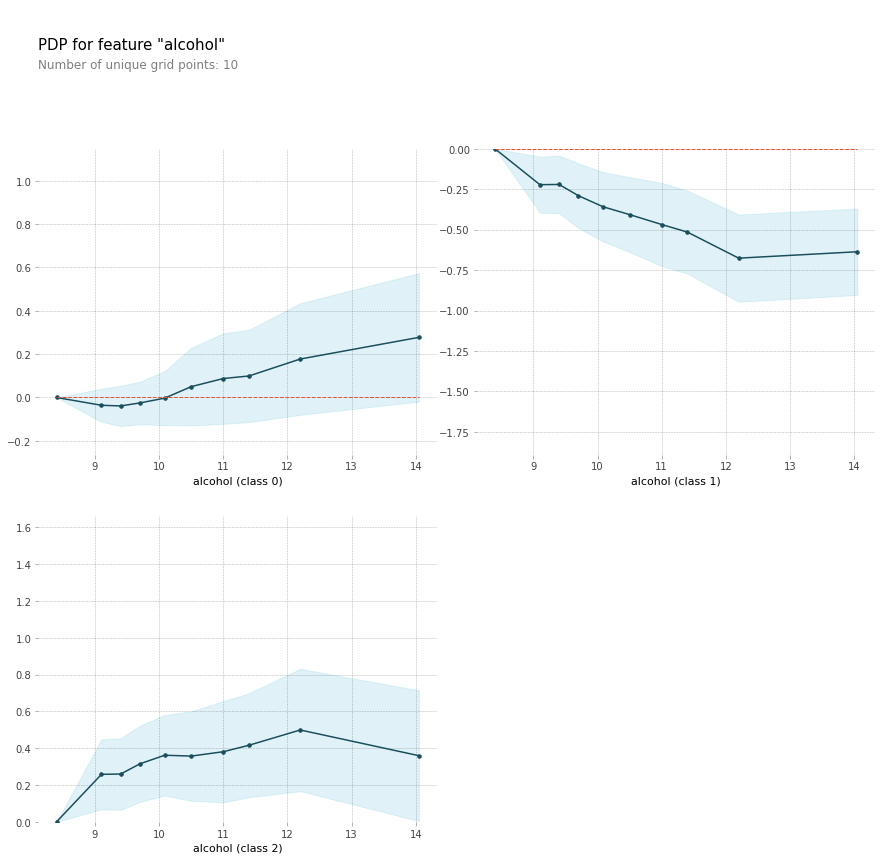

In [72]:
#i have three classes and get 3 pics
pdp_plot(isolated, feature_name= feature)

(<Figure size 1080x1080 with 4 Axes>,
 {'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f9e3224fba8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9e324bdb70>})

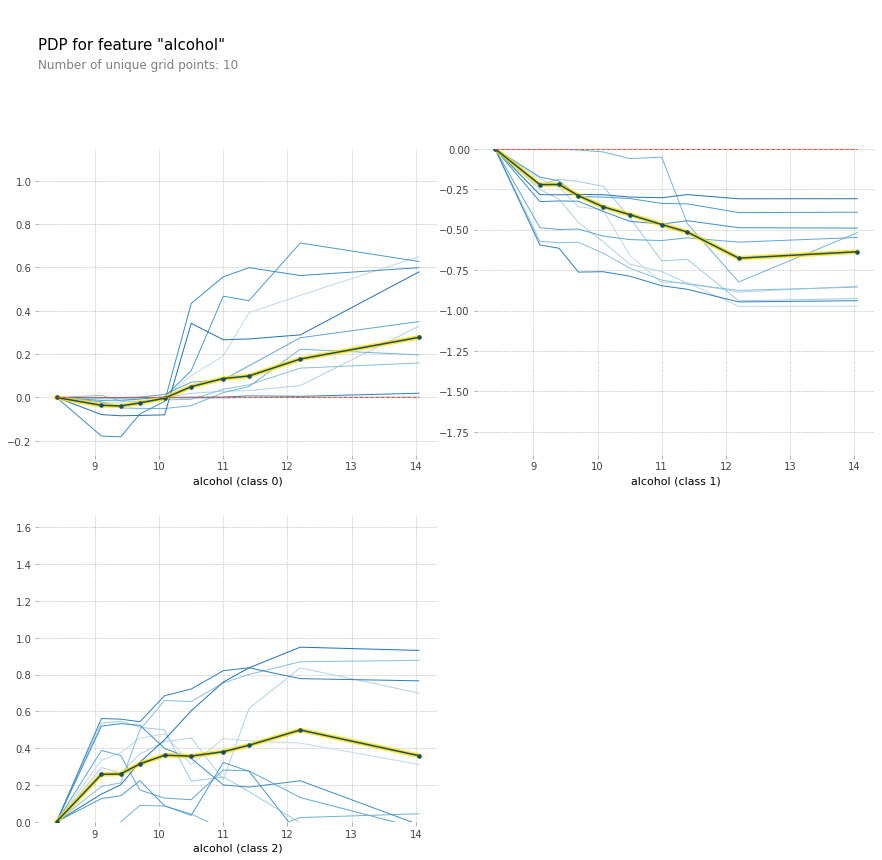

In [75]:
pdp_plot(isolated, feature_name= feature, plot_lines=True, frac_to_plot=0.01)

##Make multiple PDPs with 2 features in interaction.

In [76]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [85]:
features = ['alcohol', 'residual sugar']

interaction = pdp_interact(
    model = model,
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


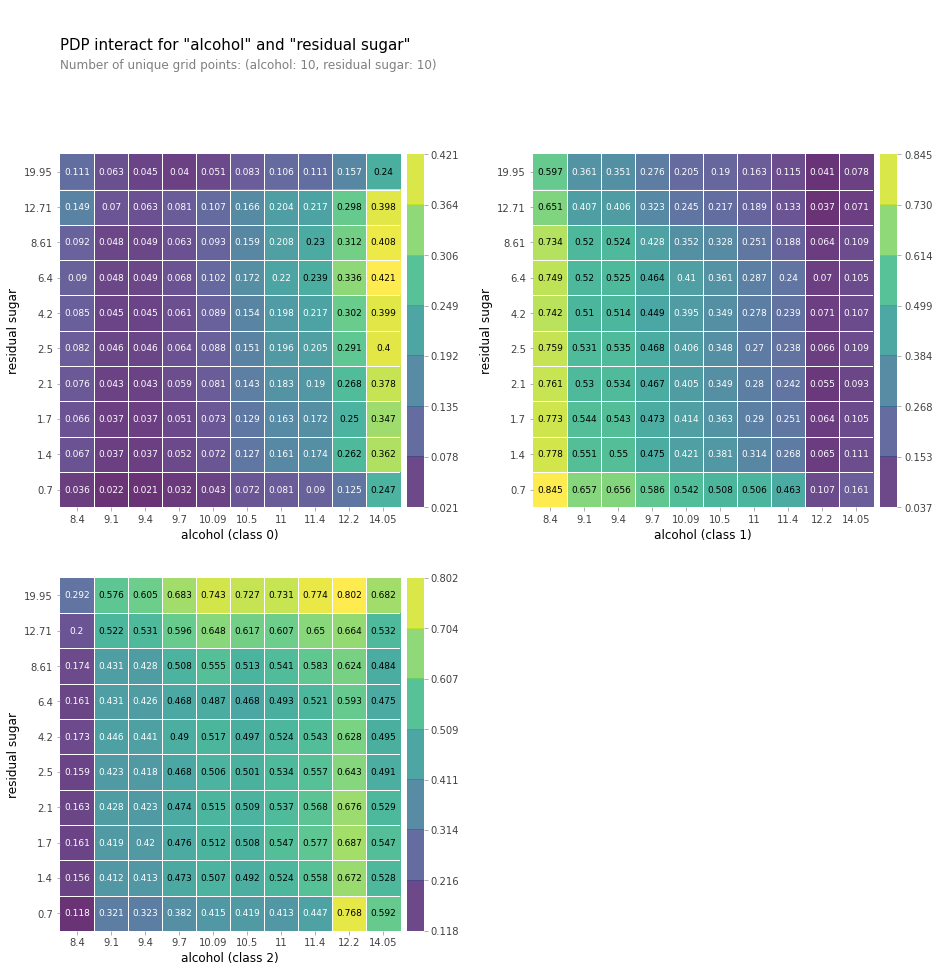

In [86]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

#Make at least 1 Shapley force plot to explain an individual prediction.

##Make Shapley force plots to explain at least 4 individual predictions.

In [97]:
import shap

for val in range(4):

  row = X_val_encoded.iloc[val]
  y_test.iloc[val]
  model.predict(row)

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(row)

  shap.initjs()
  shap.force_plot(
      base_value=explainer.expected_value, 
      shap_values=shap_values, 
      features=row)

ValueError: ignored